## First eigenvector portfolio using momentum strategy (Version2)

### Reasoning

This research is to test out the portfolio strategy using the first eigenvector extracted from the covariance matrix of cryptocurrency returns. Based on eigenvalue decomposition, the first eigenvector explains most of the variance. The next step is to apply a momentum strategy on the portfolio weighted by this eigenvector. My reasoning behind it is that the eigenvector weighted portfolio will be able to generate profits by capturing the movement of the previous day's returns.

During the exercise, risk-free rates and transaction costs are set to 0.

### Step 1: Pre-processing

In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.decomposition import PCA

Since the cryptomarket is relatively new, it is really difficult to select the right cryptos. My first approach was to find the top five cryptos in their market capitalizations. However, some of them are new in the market, so they do not have enough data. Therefore, I selected five cryptocurrencies that have or had a significant impact on the crypto market. They are Bitcoin, Ethereum, Ripple, Cardano, and Bitcoin Cash. KRW is Korean won which is the national currency.

In [2]:
tickers = ["BTC/KRW","ETH/KRW","XRP/KRW","ADA/KRW","BCH/KRW"]

In [3]:
def fetch_daily_return(tickers, start_date, end_date):
    # First, download the first ticker data
    returns = fdr.DataReader(tickers[0],start_date,end_date)
    data = returns["Change"]
    # Then, by using for-loop, we can merge the data together whenever it gets new data.
    for i in range(1,len(tickers)):
        returns = fdr.DataReader(tickers[i],start_date,end_date)
        data = pd.concat([data, returns["Change"]], axis = 1)
    # Resetting the name of each column
    for i in range(0,len(tickers)):
        names = data.columns.values
        names[i] = tickers[i]
    return data

In [4]:
df = fetch_daily_return(tickers,'2018-01-01','2021-06-01')
df = df.dropna()

In [5]:
df.tail()

,BTC/KRW,ETH/KRW,XRP/KRW,ADA/KRW,BCH/KRW
Date,,,,,
2021-05-28,-0.0618,-0.1072,-0.0638,-0.0725,-0.0712
2021-05-29,-0.0225,-0.0484,-0.0682,-0.0647,-0.0452
2021-05-30,0.0114,0.0277,0.0702,0.1037,-0.0037
2021-05-31,0.0123,0.0969,0.1121,0.0601,0.0294
2021-06-01,-0.0107,-0.0214,-0.0246,0.0074,-0.0103


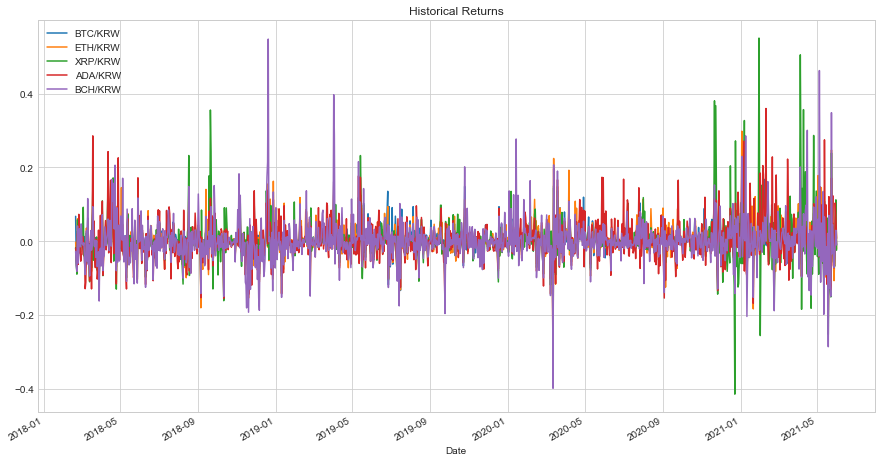

In [6]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (15,8)
df.plot(title='Historical Returns')
plt.show()

This historical return chart is difficult to observe their long-term performances. Hence I created cumulative returns to see their current locations and how their prices had changed.

In [7]:
cumulative_ret = (df + 1).cumprod()

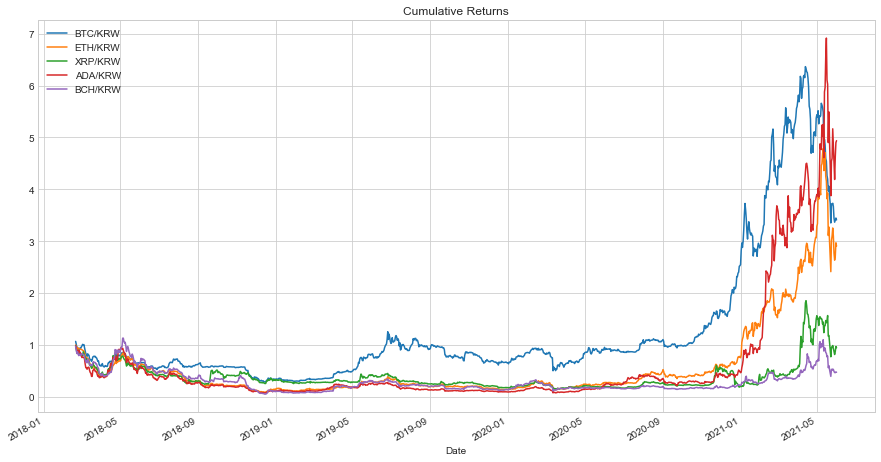

In [8]:
cumulative_ret.plot(title='Cumulative Returns')
plt.show()

<AxesSubplot:>

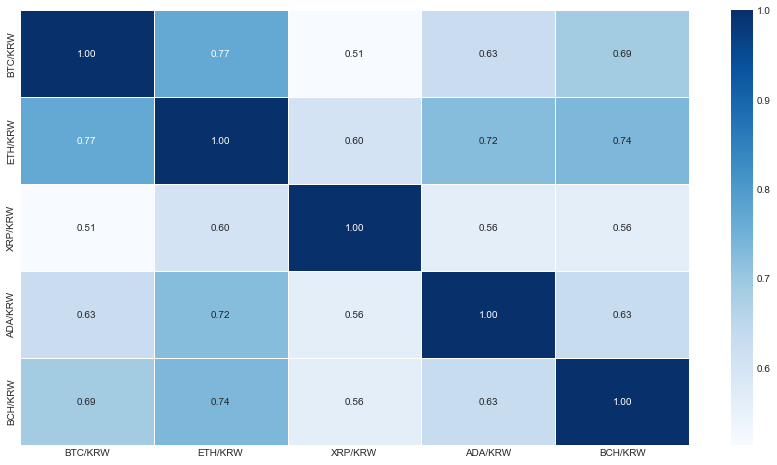

In [9]:
sb.heatmap(data = df.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

Many retail crypto traders suggest that bitcoin is the best to invest in because other cryptos will follow bitcoin's price anyway. As the correlation map shows above, indeed, all four cryptos have positive correlation with bitcoin. However, this does not imply that we can disregard other cryptos or their high risk premium. Other cryptocurrencies are usually notorious for high volatility and unstable price returns. This can be considered as an opportunity to obtain high profits.

In [10]:
## By using hitorical returns, we can calculate their geometric mean returns.
hist_return = (df+1).product()**(1/df.shape[0]) - 1
## We also get covariance and inverse covariance matrix of returns.
cov = df.cov()
cvi = np.linalg.inv(cov)

Build two portfolios, one is a classic mean-variance optimized portfolio and the other one is weighted by the first eigenvector by EVD.

1. Mean-Variance optimized portfolio formula is as follows,

$$ w^*( f) = \frac{V^{-1} f}{ f^T V^{-1}  f}$$

where $V$ is the covariance matrix and $f$ is the return

In [11]:
## Use a classical formula to optimize mean/variance and obtain the normalized weights.
weights1 = (cvi.dot(hist_return.T)) / (hist_return.T.dot(cvi).dot(hist_return))
weights1 = weights1 / weights1.sum()
display(weights1)

array([ 1.51393672,  0.33012194, -0.26894987,  0.51665254, -1.09176134])

2. Eigenvalue Decomposition is as follows,

$$A =  RV R^T$$

We will be using the first vector from $R$ in this exercise

In [12]:
## For the eigenvector portfolio, we get the first eigenvector by EVD and normalize them so they sum to one.
evalues, evectors = np.linalg.eig(cov)
weights2 = evectors[0] / sum(evectors[0])
display(weights2)

array([ 0.18886049,  0.55647054,  0.33886744, -0.10957402,  0.02537554])

### Step 2: Testing two portfolios

In [13]:
## Getting out-of-sample returns
df2 = fetch_daily_return(tickers,'2021-06-02','2022-01-01')
df2 = df2.dropna()

In [14]:
## Calculate two different returns corresponding to two different portfolio weights
ret1 = df2.dot(weights1)
ret2 = df2.dot(weights2)

In [15]:
# Add Bitcoin in the data for comparison
data2 = pd.concat([ret1,ret2, df2["BTC/KRW"]], axis = 1)

In [16]:
data2.columns.values[0] = "M-V Optimal Portfolio"
data2.columns.values[1] = "1st Eigenvector Portfolio"

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='Date'>

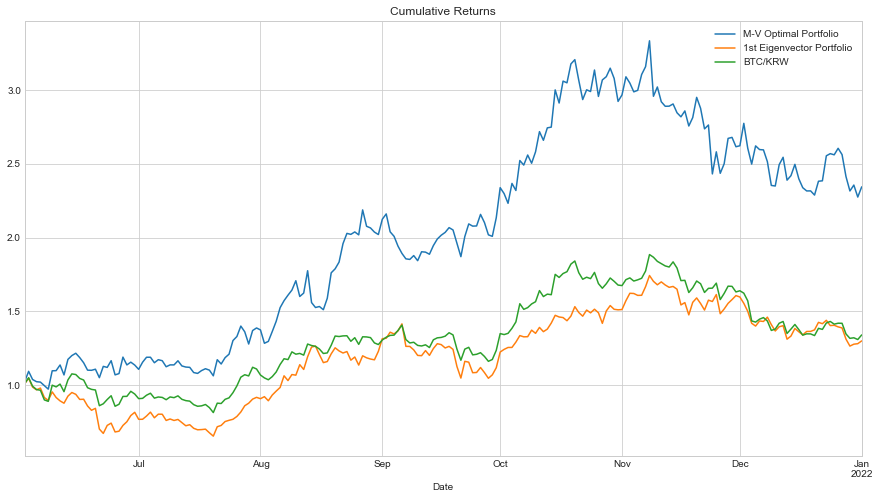

In [17]:
(data2 + 1).cumprod().plot(title='Cumulative Returns')

If we suppose holding three different portfolios, M-V optimal portfolio, first eigenvector portfolio, and Bitcion portfolio from June 2021 to December 2022, the cumulative returns can be plotted as above. M-V optimal portfolio has much better performance than the other two. More importantly, holding a single bitcoin results in better profits than the first eigenvector portfolio. Therefore, I decided to implement a leveraged momentum strategy to make the first eigenvector portfolio more useful.

### Step 3: Implementation of the momentum strategy

In [18]:
decision = df2.copy()
## The components of this matrix will change to 5 if return is higher than 0.03, else they will be 0.
decision = np.where(decision > 0.03, 5, 0)

Here, 5 can be considered as leverage to 1. However, we do not take any positions for cryptos that have returns of less than 0.03. For the first eigenvector portfolio, its leverage ratio will not always be 5:1. The possible maximum leverage ratio is 5, only when we take all possible positions. However, for the mean-variance optimal portfolio and single Bitcoin portfolio, leverage ratios can definitely become 5:1 or even more. It must be recognized that it is an aggressive strategy to take advantage of huge fluctuations derived from optimism in crypto markets.

In [19]:
#How decision matrix looks like...
display(decision)

array([[0, 0, 0, 0, 0],
       [5, 5, 0, 5, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0]])

In [20]:
## Since we need to use the one day lagged return to calculate the decision matrix, 
## we must use returns from 2021-06-03, instead of 2021-06-02.
ret = df2.iloc[1:,:]
ret.head()

,BTC/KRW,ETH/KRW,XRP/KRW,ADA/KRW,BCH/KRW
Date,,,,,
2021-06-03,0.0393,0.0505,0.0151,0.0466,0.0265
2021-06-04,-0.0543,-0.0529,-0.0678,-0.0703,-0.0618
2021-06-05,-0.0231,-0.0086,-0.0328,-0.0151,-0.0205
2021-06-06,-0.0048,0.0174,0.0101,0.0000,-0.0013
2021-06-07,-0.0677,-0.0475,-0.0917,-0.0691,-0.0974


In [21]:
weights3 = np.array([1,0,0,0,0]) #This portfolio contains only Bitcoin.
weights = [weights1,weights2,weights3] #weights1:M-V optimal portfolio, weights2: 1st Eigenvector portfolio
columns = ["Dynamic M-V","Dynamic EV","Dynamic BTC"]

In [22]:
for i in range(3):
    dyn_weights = decision * weights[i] # Pairwise multiplication to obtain dynamic weights
    dyn_weights = np.delete(dyn_weights, 213,0)# Since weights are one day lagged, we do not need the last day's return.
    dyn_ret = np.empty((dyn_weights.shape[0]))# Create empty array to store dynamic returns.

    for j in range(0,dyn_weights.shape[0]):
        dyn_ret[j] = np.dot(dyn_weights[j],ret.values[j]) # Calculate each day's return with dynamic weights
    
    dyn_ret = pd.Series(dyn_ret) # Convert array to Series
    dyn_ret.index = ret.index # Get 'Date' as an index
    data2 = pd.concat([data2, dyn_ret], axis = 1) # merge data for visualization
    
    data2.rename(columns={0:columns[i]}, inplace=True)


data2 = data2.dropna()

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='Date'>

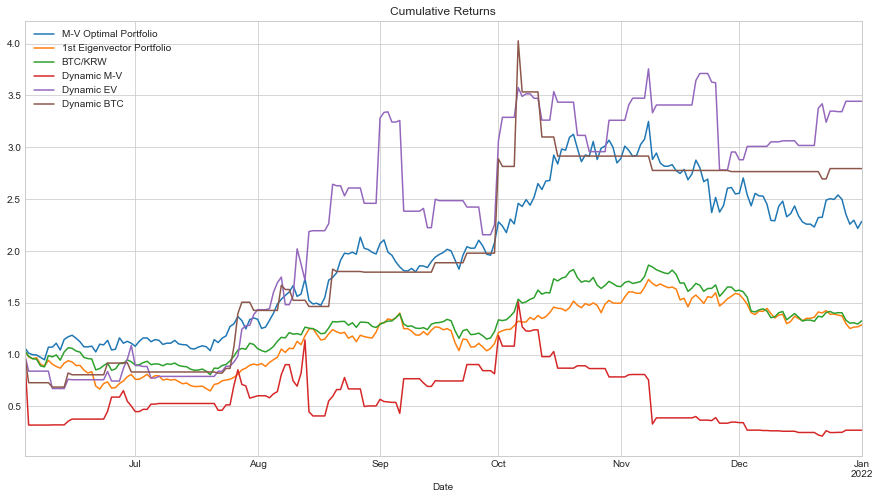

In [23]:
(data2 + 1).cumprod().plot(title='Cumulative Returns')

As the graph above shows, after the momentum strategy was applied to three different portfolios, they had many different results than before.

Our dynamic eigenvector portfolio outperformed all portfolios at the end date, even including the static Mean-Variance portfolio, which had the best performance among other static portfolios. 

Mean-variance optimal portfolio is not suitable for the momentum strategy. In fact, the strategy made it the worst portfolio among others. I assume this is because of the weights of the portfolio. It is very common to observe that mean-variance optimal portfolios have excessive weights on specific assets. Leverage made these weights more excessive, so its total leverage ratio can become much larger than 5:1. Hence, when the strategy is not working, it has to accept a huge loss.

Dynamic Bitcoin portfolio has quite a good performance compared to other portfolios, but this portfolio will always have a 5:1 leverage ratio when it is invested. Whenever bitcoin's return is higher than 0.03, we invest in it with a 5:1 leverage ratio because it is not a diversified portfolio. This implies that this portfolio requires more budget than the first eigenvector portfolio in order to generate its cumulative returns.

### Conclusion

Portfolio construction using the eigenvectors can be useful when there is a suitable strategy. However, this model definitely needs some improvements by adding and changing parameters, such as threshold returns, leverage ratio, etc. Also, when a decision matrix is made, there must be additional conditions to consider. For example, when returns are lower than a specific threshold, we can try to short corresponding cryptos. In this way, we can get back our lost trading opportunities.

Since this portfolio requires high leverage, setting up the indicator for stop-loss also should be considered. If there can be more research regarding movements of returns, we will be able to set up parameters more efficiently to avoid losses.